<a href="https://colab.research.google.com/github/aefif77/FYP_Project/blob/main/FYP_CrudeOilPrice_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.2 MB/s eta 0:00:00


In [ ]:
!pip install tensorflow --quiet


In [ ]:
#Libraries
import numpy as np
import pandas as pd
from math import sqrt
import time

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='whitegrid')
sns.set_context(context='paper',font_scale=1.5)
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

from datetime import datetime, timedelta
from tqdm import tqdm

import itertools


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
wti_price = pd.read_csv('/content/drive/MyDrive/FYP PROJECT/DATASETS/WTI Crude Oil Price Dataset  - WTI Price Data (Dr. Marina).csv')
brent_price = pd.read_csv('/content/drive/MyDrive/FYP PROJECT/DATASETS/WTI Crude Oil Price Dataset  - BRENT Price Data (Dr.Marina).csv')

In [ ]:
pd.concat([wti_price.head(), wti_price.tail()]) #5433 instances

,Date,Price
0,04/15/2021,63.51
1,04/14/2021,63.22
2,04/13/2021,60.24
3,04/12/2021,59.75
4,04/09/2021,59.35
5429,01/10/2000,24.67
5430,01/07/2000,24.22
5431,01/06/2000,24.78
5432,01/05/2000,24.91
5433,01/04/2000,25.55


In [ ]:
wti_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5434 entries, 0 to 5433
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    5434 non-null   object 
 1   Price   5434 non-null   float64
dtypes: float64(1), object(1)
memory usage: 85.0+ KB


In [ ]:
wti_price.isna().sum()

,0
Date,0
Price,0


In [ ]:
pd.concat([brent_price.head(), brent_price.tail()]) #5461 instances

,Date,Price
0,04/15/2021,66.94
1,04/14/2021,66.58
2,04/13/2021,63.67
3,04/12/2021,63.28
4,04/09/2021,62.95
5457,01/10/2000,23.73
5458,01/07/2000,23.09
5459,01/06/2000,23.62
5460,01/05/2000,23.73
5461,01/04/2000,24.39


In [ ]:
brent_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5462 entries, 0 to 5461
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    5462 non-null   object 
 1   Price   5462 non-null   float64
dtypes: float64(1), object(1)
memory usage: 85.5+ KB


In [ ]:
brent_price.isna().sum()

,0
Date,0
Price,0


In [ ]:
# Convert the date to dateimte object
wti_price['Date'] = pd.to_datetime(wti_price['Date'], format='%m/%d/%Y')

print(wti_price['Date'].dtype)

datetime64[ns]


In [ ]:
wti_df = wti_price
wti_df

# Change the index of the Df as date index
# wti_df.index = pd.date_range(start='02-04-2014', end='02-05-2024', freq='D')
wti_df = wti_price.set_index('Date')
wti_df

,Price
Date,
2021-04-15,63.51
2021-04-14,63.22
2021-04-13,60.24
2021-04-12,59.75
2021-04-09,59.35
...,...
2000-01-10,24.67
2000-01-07,24.22
2000-01-06,24.78


In [ ]:
# Convert the date to dateimte object
brent_price['Date'] = pd.to_datetime(brent_price['Date'], format='%m/%d/%Y')

print(brent_price['Date'].dtype)

datetime64[ns]


In [ ]:
brent_df = brent_price
brent_df

# Change the index of the Df as date index
# wti_df.index = pd.date_range(start='02-04-2014', end='02-05-2024', freq='D')
brent_df = brent_price.set_index('Date')
brent_df

,Price
Date,
2021-04-15,66.94
2021-04-14,66.58
2021-04-13,63.67
2021-04-12,63.28
2021-04-09,62.95
...,...
2000-01-10,23.73
2000-01-07,23.09
2000-01-06,23.62


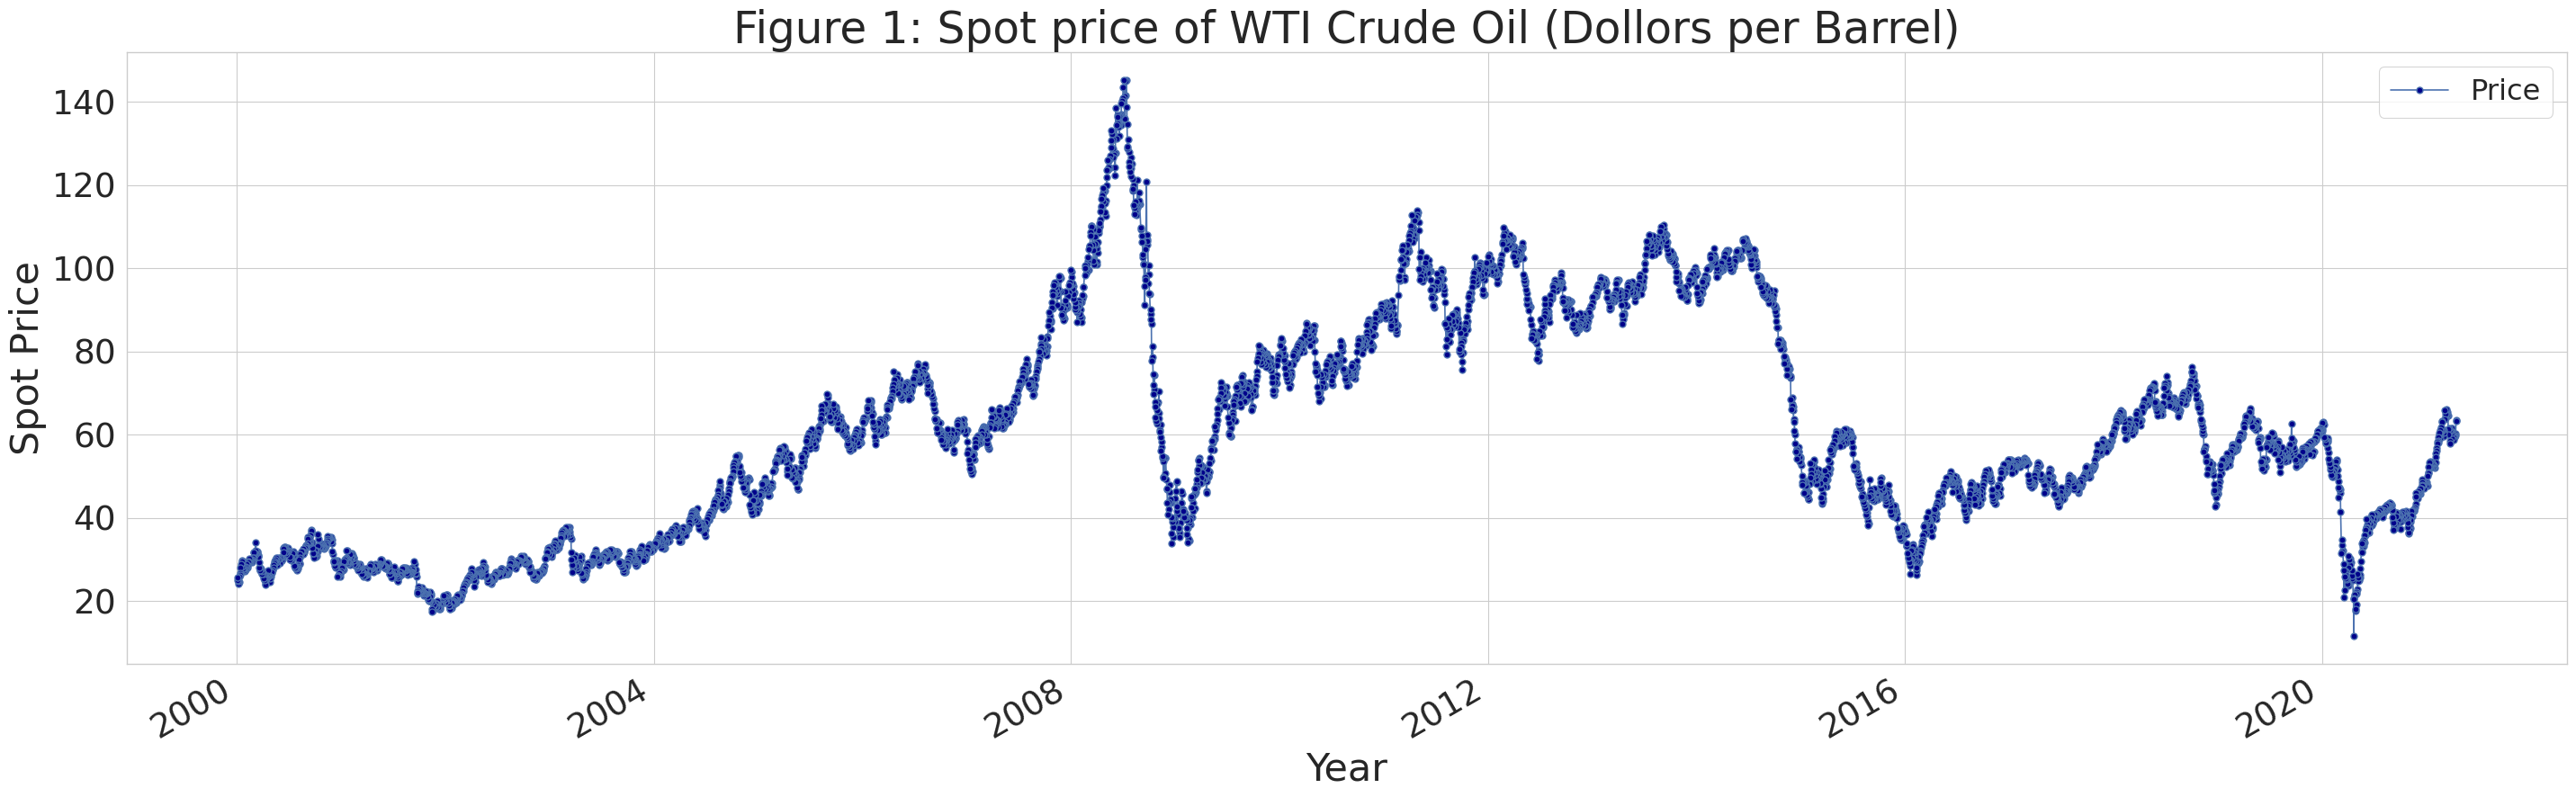

In [ ]:
# Time Series Plot of the WTI data
fig_1 = wti_df.squeeze().plot(figsize=(35,10),markersize=10, markerfacecolor= 'darkblue',marker='.',grid=True)
plt.legend(fontsize=23)
plt.title("Figure 1: Spot price of WTI Crude Oil (Dollors per Barrel)",fontsize=35)
plt.xlabel("Year", fontsize=31)
plt.ylabel("Spot Price",fontsize=31)
plt.xticks(fontsize=27)
plt.yticks(fontsize=27)
plt.savefig('fig_1_WTI_ts.png')

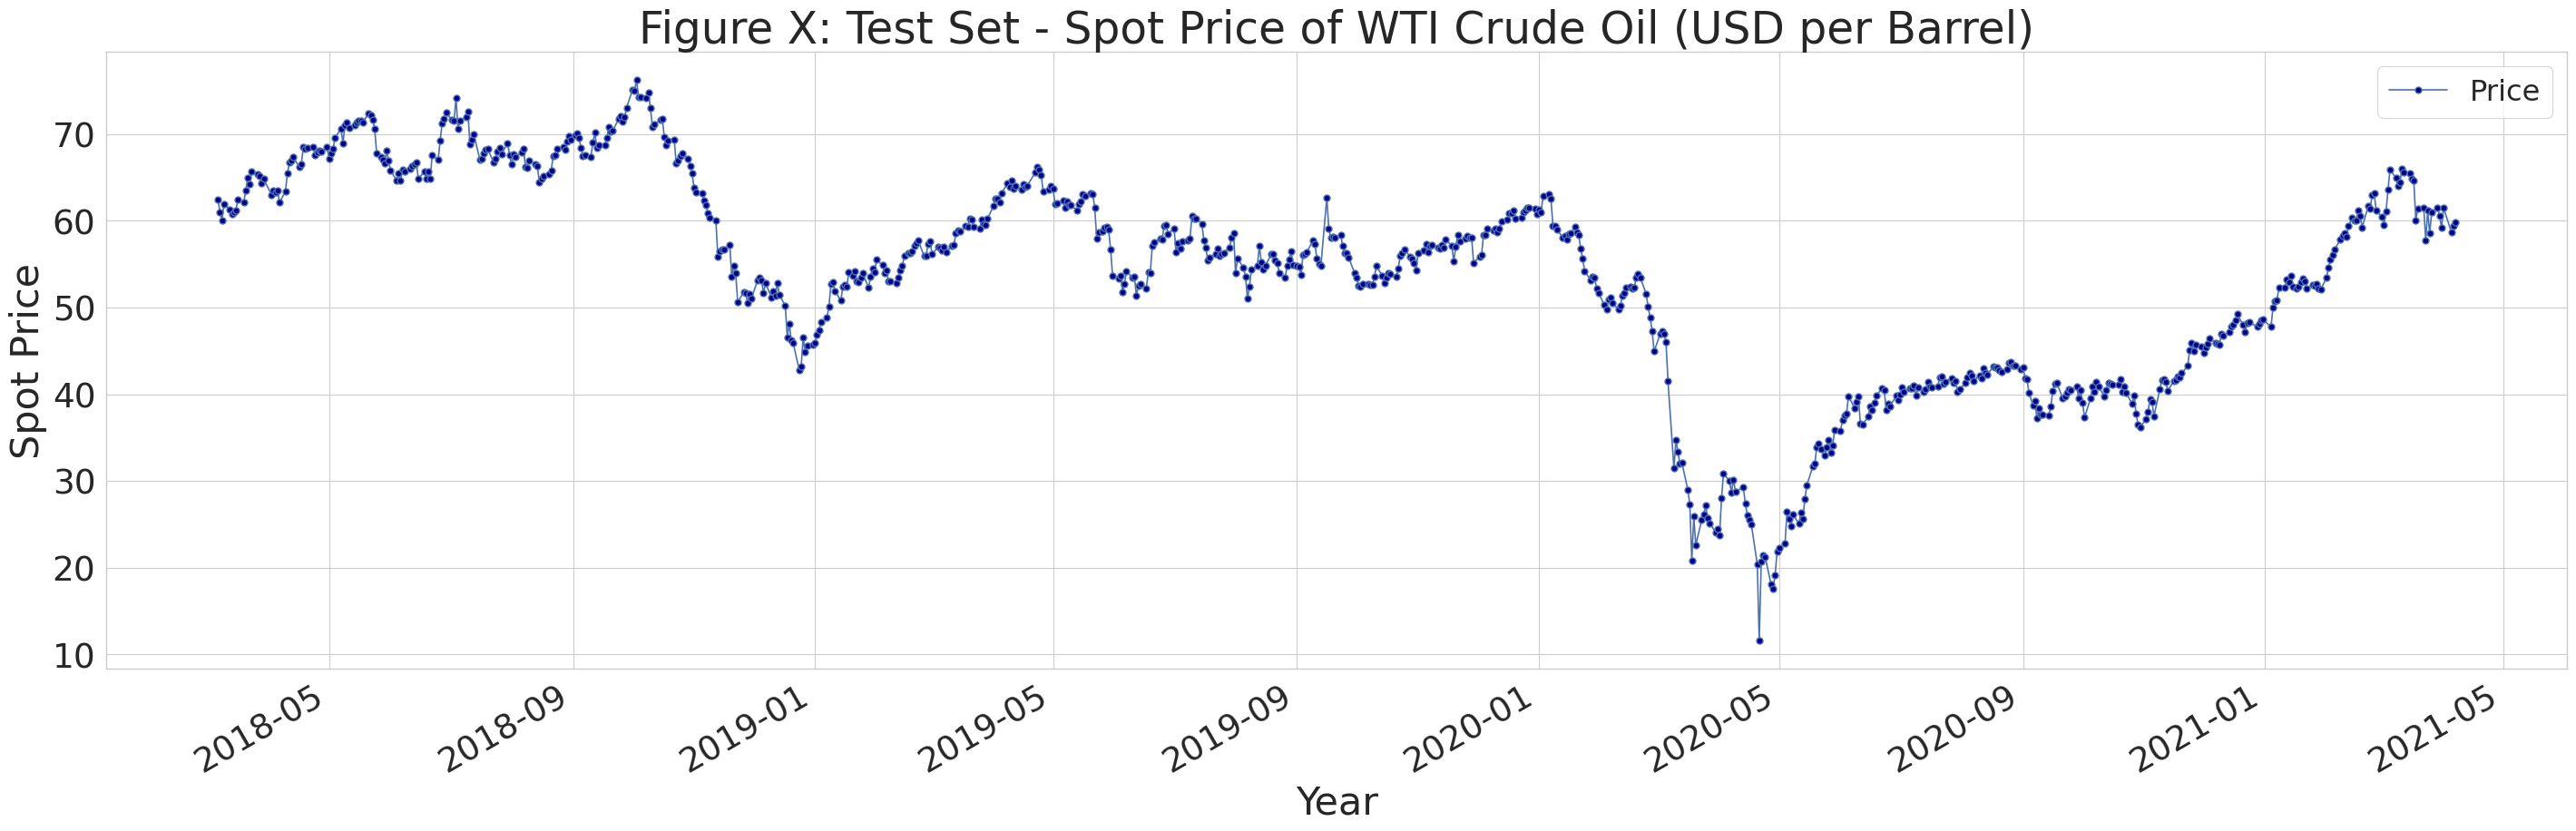

In [ ]:

# Sort the DataFrame by its index (Date)
wti_df = wti_df.sort_index()

wti_test_only = wti_df.loc['2018-03-06':'2021-04-07']

# Plot the test set time series
fig_1 = wti_test_only.squeeze().plot(
    figsize=(35, 10),
    markersize=10,
    markerfacecolor='darkblue',
    marker='.',
    grid=True
)

plt.legend(fontsize=23)
plt.title("Figure X: Test Set - Spot Price of WTI Crude Oil (USD per Barrel)", fontsize=35)
plt.xlabel("Year", fontsize=31)
plt.ylabel("Spot Price", fontsize=31)
plt.xticks(fontsize=27)
plt.yticks(fontsize=27)
plt.savefig('fig_testset_WTI_ts.png')

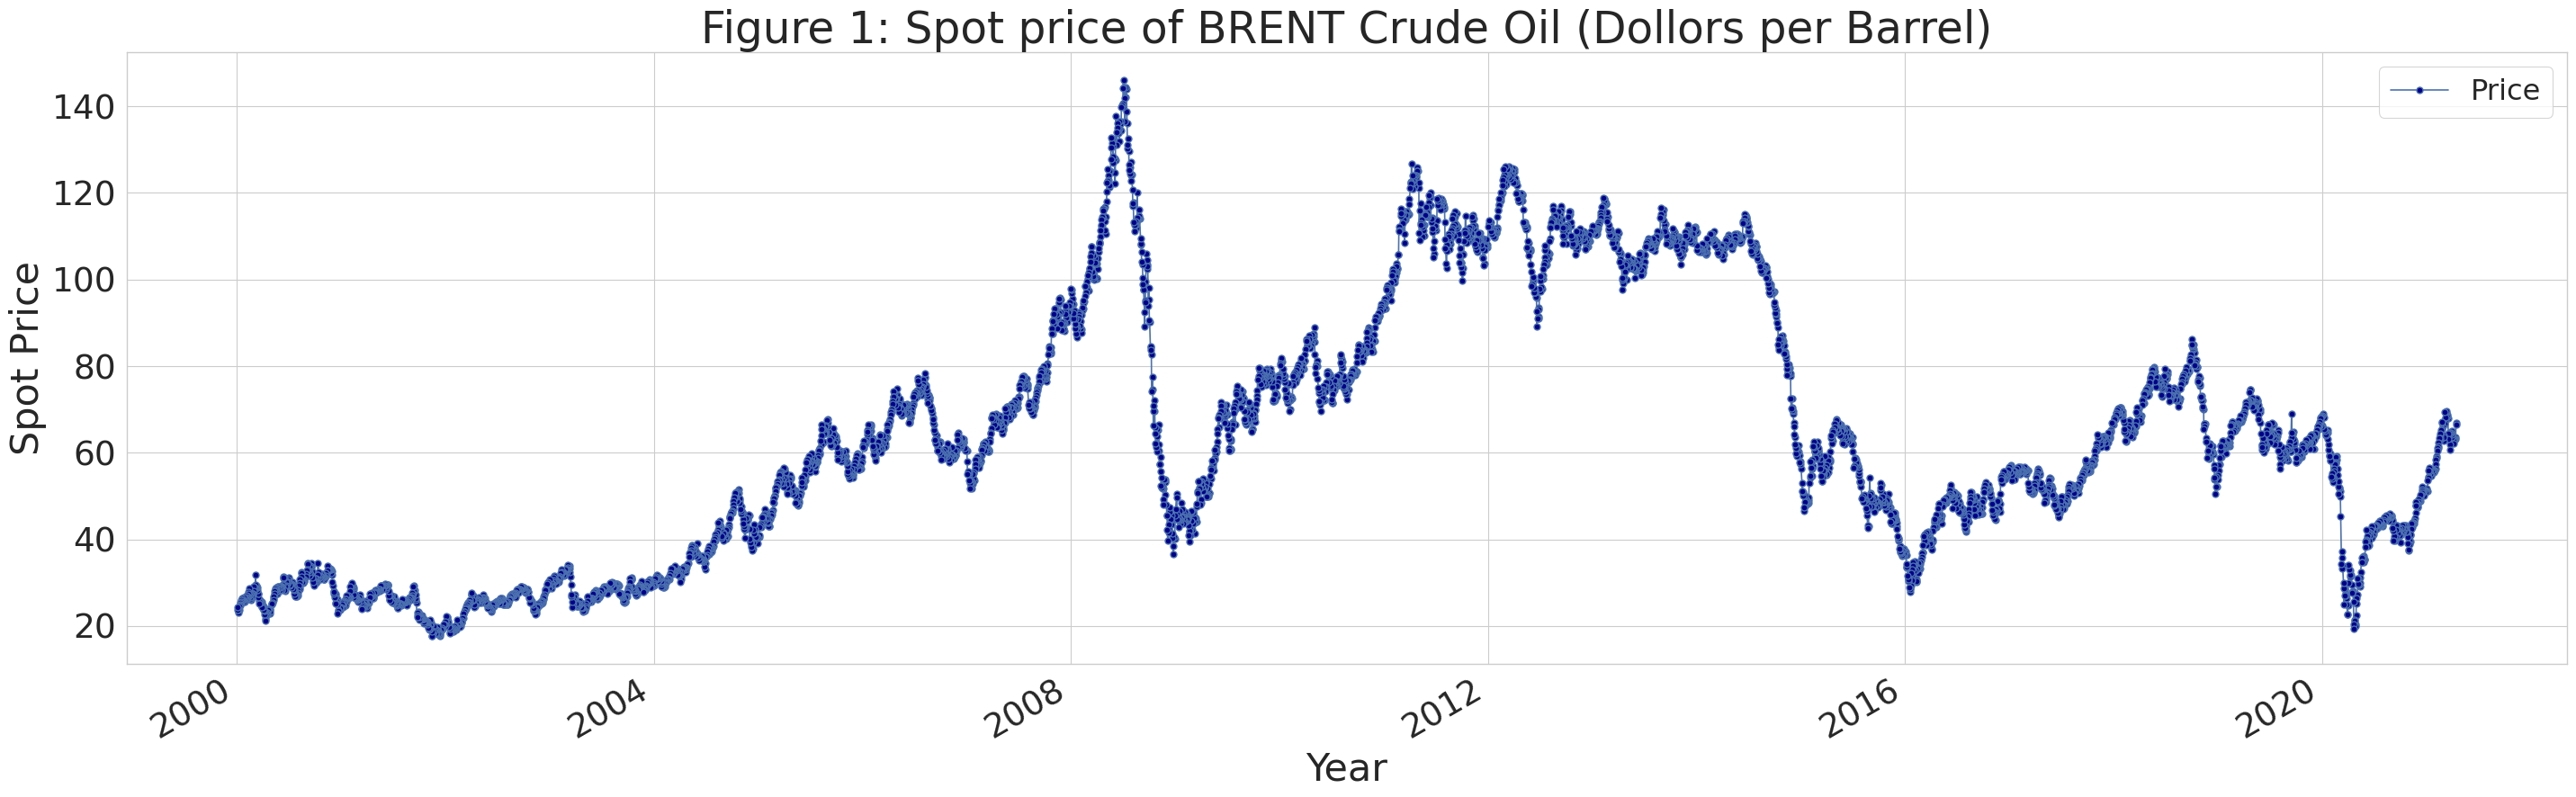

In [ ]:
# Time Series Plot of the Brent data
fig_5 = brent_df.squeeze().plot(figsize=(35,10),markersize=10, markerfacecolor= 'darkblue',marker='.',grid=True)
plt.legend(fontsize=23)
plt.title("Figure 1: Spot price of BRENT Crude Oil (Dollors per Barrel)",fontsize=35)
plt.xlabel("Year", fontsize=31)
plt.ylabel("Spot Price",fontsize=31)
plt.xticks(fontsize=27)
plt.yticks(fontsize=27)
plt.savefig('fig_1_BRENT_ts.png')

WTI missing values:
 Price    0
dtype: int64 



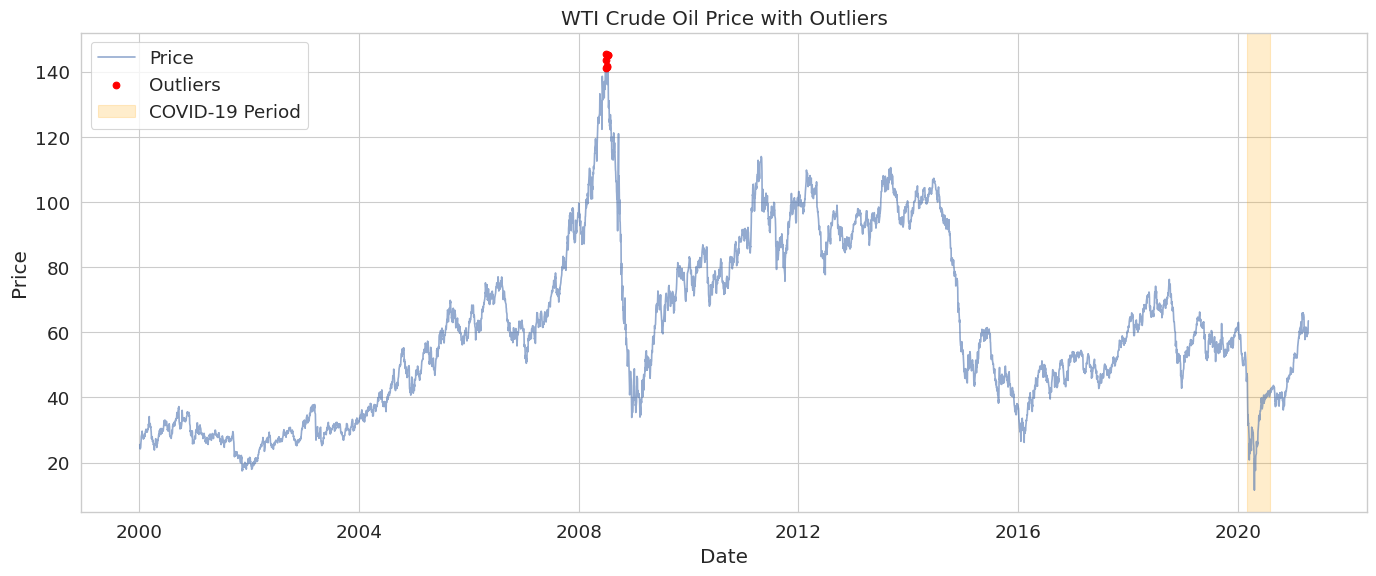

Dropped 7 non-COVID outliers. Final rows: 5427


,Price,is_covid,is_outlier
Date,,,
2000-01-04,25.55,0,False
2000-01-05,24.91,0,False
2000-01-06,24.78,0,False
2000-01-07,24.22,0,False
2000-01-10,24.67,0,False
...,...,...,...
2021-04-09,59.35,0,False
2021-04-12,59.75,0,False
2021-04-13,60.24,0,False


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def show_missing(df, name):
    print(f"{name} missing values:\n", df.isna().sum(), "\n")

show_missing(wti_df, 'WTI')

def detect_iqr_outliers_visual(df, col='Price', mult=1.5,
                                covid_start='2020-03-01', covid_end='2020-07-31'):
    df = df.copy()

    # Ensure Date is the index and in datetime format
    df.index = pd.to_datetime(df.index)

    # Tag COVID-19 period
    df['is_covid'] = ((df.index >= pd.to_datetime(covid_start)) &
                      (df.index <= pd.to_datetime(covid_end))).astype(int)

    # Calculate IQR on non-COVID data
    non_covid_data = df[df['is_covid'] == 0]
    Q1, Q3 = non_covid_data[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower, upper = Q1 - mult * IQR, Q3 + mult * IQR

    # Flag non-COVID outliers
    df['is_outlier'] = ((df[col] < lower) | (df[col] > upper)) & (df['is_covid'] == 0)

    # Cleaned data
    df_cleaned = df[~df['is_outlier']].copy()

    # Plotting
    plt.figure(figsize=(14, 6))
    plt.plot(df.index, df[col], label='Price', alpha=0.6)
    plt.scatter(df[df['is_outlier']].index, df[df['is_outlier']][col],
                color='red', label='Outliers', zorder=5)
    plt.axvspan(pd.to_datetime(covid_start), pd.to_datetime(covid_end),
                color='orange', alpha=0.2, label='COVID-19 Period')
    plt.title('WTI Crude Oil Price with Outliers')
    plt.xlabel('Date')
    plt.ylabel(col)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"Dropped {df['is_outlier'].sum()} non-COVID outliers. Final rows: {len(df_cleaned)}")
    return df_cleaned, df

wti_clean, wti_flagged = detect_iqr_outliers_visual(wti_df, col='Price')

wti_flagged

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split # Although not used for splitting here

# --- Step 1: Create lagged feature set (sliding window) ---
def make_sliding_window_df(series, window_size):
    """
    Creates a sliding window DataFrame from a single time series.

    Args:
        series (pd.Series): The input time series (should be a pandas Series).
        window_size (int): The number of previous time steps to use as features.

    Returns:
        pd.DataFrame: DataFrame with lagged features and the target.
    """
    df = pd.DataFrame()
    for lag in range(window_size, 0, -1):
        # Ensure we are shifting the single series, not a potential DataFrame
        df[f'lag_{lag}'] = series.shift(lag)
    df['target'] = series
    return df.dropna()

# --- Step 2: Normalize and Split ---
def normalize_and_split(dataframe, test_size=0.20, val_size=0.20, scale_target=False):
    """
    Normalizes features and splits data into train, validation, and test sets
    chronologically.

    Args:
        dataframe (pd.DataFrame): DataFrame with lagged features and target.
        test_size (float): Proportion of the dataset to include in the test split.
        val_size (float): Proportion of the non-test dataset to include in the validation split.
        scale_target (bool): Whether to scale the target variable.

    Returns:
        tuple: Scaled train, val, test features and targets, plus scalers.
    """
    dataframe = dataframe.sort_index()

    X = dataframe.drop('target', axis=1)
    y = dataframe['target']

    total_len = len(X)
    # Calculate split sizes, ensuring they are integers
    test_len = int(total_len * test_size)
    # Calculate remaining length after reserving test data
    remaining_len = total_len - test_len
    val_len = int(remaining_len * (val_size / (1 - test_size))) # Calculate val size as proportion of remaining
    train_len = total_len - test_len - val_len # Assign remaining to train

    # Ensure lengths sum up to total_len (handle potential floating point issues)
    # In case of small discrepancies, add/remove from train
    current_sum = train_len + val_len + test_len
    if current_sum != total_len:
        train_len += (total_len - current_sum)


    # Split: [train | val | test]
    X_train = X.iloc[:train_len]
    y_train = y.iloc[:train_len]

    X_val = X.iloc[train_len:train_len + val_len]
    y_val = y.iloc[train_len:train_len + val_len]

    X_test = X.iloc[train_len + val_len:]
    y_test = y.iloc[train_len + val_len:]

    # Normalize features
    scaler_X = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_val_scaled = scaler_X.transform(X_val)
    X_test_scaled = scaler_X.transform(X_test)

    # Convert back to DataFrame with original index and column names for clarity
    X_train_scaled_df = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
    X_val_scaled_df = pd.DataFrame(X_val_scaled, index=X_val.index, columns=X_val.columns)
    X_test_scaled_df = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)


    if scale_target:
        scaler_y = StandardScaler()
        y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
        y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1)).flatten()
        y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()
        # Return scaled y values
        y_train_out, y_val_out, y_test_out = y_train_scaled, y_val_scaled, y_test_scaled
    else:
        scaler_y = None
        # Return original y values
        y_train_out, y_val_out, y_test_out = y_train, y_val, y_test


    # --- Reporting ---
    print("\n--- Lagged Feature Dataset Preview ---")
    # Print preview of the DataFrame before normalization and splitting
    # Ensure wti_feats exists and is representative
    if 'wti_feats' in locals():
         print(wti_feats.head())


    print("\n--- Dataset Split Summary ---")
    print(f"Total samples in lagged data: {total_len}")
    print(f"Training samples: {len(X_train_scaled_df)} | Dates: {X_train_scaled_df.index[0].date()} → {X_train_scaled_df.index[-1].date()}")
    print(f"Validation samples: {len(X_val_scaled_df)} | Dates: {X_val_scaled_df.index[0].date()} → {X_val_scaled_df.index[-1].date()}")
    print(f"Test samples: {len(X_test_scaled_df)} | Dates: {X_test_scaled_df.index[0].date()} → {X_test_scaled_df.index[-1].date()}")

    return (X_train_scaled_df, X_val_scaled_df, X_test_scaled_df,
            y_train_out, y_val_out, y_test_out,
            scaler_X, scaler_y)

# --- Step 3: Apply on differenced series (or original series) ---
lookback = 3 # sliding window length

# Assuming wti_clean is the DataFrame containing the 'Price' series with a DatetimeIndex
# Pass only the 'Price' column (as a Series) to make_sliding_window_df
if 'wti_clean' in locals() and isinstance(wti_clean, pd.DataFrame) and 'Price' in wti_clean.columns:
     wti_price_series = wti_clean['Price']
else:
     # Fallback or error handling if wti_clean or Price column is missing
     raise ValueError("wti_clean DataFrame with 'Price' column is required.")


wti_feats = make_sliding_window_df(wti_price_series, window_size=lookback)

# Now split and scale
# Pass the DataFrames with indexes back from normalize_and_split
X_train_scaled_df, X_val_scaled_df, X_test_scaled_df, y_train, y_val, y_test, scaler_X, scaler_y = normalize_and_split(
    wti_feats,
    test_size=0.20,
    val_size=0.20,
    scale_target=False # Keep target in original scale if predicting price directly
)

# You can now use X_train_scaled_df, y_train, etc. for model training


--- Lagged Feature Dataset Preview ---

--- Dataset Split Summary ---
Total samples in lagged data: 5424
Training samples: 3255 | Dates: 2000-01-04 → 2013-01-03
Validation samples: 1085 | Dates: 2013-01-04 → 2017-02-27
Test samples: 1084 | Dates: 2017-02-28 → 2021-04-12


In [ ]:
import time
import numpy as np
import pandas as pd
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, ParameterGrid, RandomizedSearchCV
from lightgbm import LGBMRegressor
import lightgbm as lgb # Import lightgbm for early stopping callback

# Assume you already have:
# X_train_scaled_df, X_val_scaled_df, X_test_scaled_df, y_train, y_val, y_test from your data preparation step

# 1) Define an n-fold time-series CV on your training data
tscv = TimeSeriesSplit(n_splits=5)

# 2) Define a more comprehensive parameter distribution for RandomizedSearchCV
# Expanded parameter grid for more thorough tuning
param_dist_lgbm = {
    'n_estimators': [500, 1000, 1500, 2000, 3000],
    'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7, 10, 15, 20, -1], # -1 means no limit
    'num_leaves': [20, 31, 50, 100, 200],
    'min_child_samples': [10, 20, 30, 50, 100],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.001, 0.01, 0.1, 0.5, 1.0], # L1 regularization
    'reg_lambda': [0, 0.001, 0.01, 0.1, 0.5, 1.0], # L2 regularization
    'boosting_type': ['gbdt'], # Starting with gbdt, can add 'dart' later if needed
    # 'bagging_fraction': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0], # For 'dart' or 'gbdt' with bagging_freq > 0
    # 'bagging_freq': [0, 1, 5, 10, 20], # For 'dart' or 'gbdt' with bagging_fraction < 1.0
}


def tune_with_tscv(X, y, cv, param_distributions, n_iter=100):
    best_score = float('inf')
    best_params = None

    # Use RandomizedSearchCV directly
    lgbm_base = LGBMRegressor(random_state=42)

    # Note: Early stopping with 'dart' boosting_type might not work as expected
    # We will use callbacks for early stopping during the final fit, not typically in CV tuning itself
    # unless evaluating based on best iteration. Here, we'll evaluate based on full n_estimators or early stopping in final fit.

    search = RandomizedSearchCV(
        estimator=lgbm_base,
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=cv,
        scoring='neg_root_mean_squared_error', # Use negative RMSE to maximize
        random_state=42,
        n_jobs=-1, # Use all available cores
        verbose=2  # Increase verbosity to see progress
    )

    start = time.time()
    # Fit RandomizedSearchCV on the training data
    search.fit(X, y)
    elapsed = time.time() - start
    print(f"\nRandomizedSearchCV took {elapsed:.1f}s")

    best_params = search.best_params_
    cv_results_df = pd.DataFrame(search.cv_results_)

    return best_params, cv_results_df


# 3) Run tuning with expanded grid and more iterations
start = time.time()
# Pass the scaled DataFrames/Series and the expanded param_dist
best_params, cv_results = tune_with_tscv(
    X_train_scaled_df, y_train, tscv, param_dist_lgbm, n_iter=200 # Increased n_iter
)
print(f"\nOverall Tuning done in {time.time()-start:.1f}s")

print("\n=== CV RESULTS (Top 10) ===")
# Print the top 10 results from the CV
display(cv_results.sort_values('rank_test_score').head(10))

print("\n=== BEST PARAMS ===")
for k, v in best_params.items():
    print(f"{k}: {v}")

# 4) Retrain on full training set with best params + early stopping on validation set
final_model_params = best_params.copy()
# Ensure boosting_type is a string if it came from a list in param_dist
if isinstance(final_model_params.get('boosting_type'), list):
     final_model_params['boosting_type'] = final_model_params['boosting_type'][0]


model = LGBMRegressor(**final_model_params, random_state=42)

# Use the separate validation set for early stopping
# Be aware that early stopping might not work with boosting_type='dart'
final_callbacks = []
if final_model_params.get('boosting_type') != 'dart':
    final_callbacks = [lgb.early_stopping(stopping_rounds=50, verbose=10)]
else:
    print("Warning: Early stopping is typically not effective or supported with boosting_type='dart'")


model.fit(
    X_train_scaled_df, y_train,
    eval_set=[(X_val_scaled_df, y_val)], # Use the validation set here
    eval_metric='rmse',
    callbacks=final_callbacks # Pass callbacks here
)

# 5) Final evaluation on test
# Predict on the scaled test features
y_pred = model.predict(X_test_scaled_df) # Renamed from y_pred_scaled to avoid confusion with potential target scaling


# Since the target (y_test) was NOT scaled, we evaluate directly
print("\n=== TEST PERFORMANCE (Original Target) ===")
print(f"RMSE: {sqrt(mean_squared_error(y_test, y_pred)):.4f}")
print(f"MAE : {mean_absolute_error(y_test, y_pred):.4f}")

# The evaluation is already on the original price scale because y_test is on the original scale.
# No need for a separate print statement for "Original Price Scale".

Fitting 5 folds for each of 200 candidates, totalling 1000 fits

RandomizedSearchCV took 1036.3s

Overall Tuning done in 1036.3s

=== CV RESULTS (Top 10) ===


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_reg_lambda,param_reg_alpha,param_num_leaves,param_n_estimators,param_min_child_samples,...,param_boosting_type,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
178,3.090362,0.254258,0.415780,0.094309,1.0,0.010,0.100,50,3000,10,...,gbdt,"{'subsample': 1.0, 'reg_lambda': 0.01, 'reg_al...",-1.086968,-19.280669,-23.993133,-2.320621,-2.164436,-9.769165,9.813085,1
30,1.038094,0.255587,0.158615,0.045936,0.8,0.500,0.001,20,2000,10,...,gbdt,"{'subsample': 0.8, 'reg_lambda': 0.5, 'reg_alp...",-1.111810,-19.242993,-23.958899,-2.334179,-2.265598,-9.782696,9.773775,2
95,1.745655,0.345382,0.230103,0.043117,0.7,0.001,0.001,20,1500,10,...,gbdt,"{'subsample': 0.7, 'reg_lambda': 0.001, 'reg_a...",-1.100451,-19.313737,-24.059862,-2.316824,-2.130439,-9.784263,9.842315,3
61,0.328105,0.049330,0.029438,0.008158,0.7,1.000,0.001,50,500,10,...,gbdt,"{'subsample': 0.7, 'reg_lambda': 1.0, 'reg_alp...",-1.115131,-19.258381,-23.959846,-2.315195,-2.282934,-9.786297,9.776674,4
163,1.757025,0.177371,0.175636,0.019206,0.6,0.000,0.001,20,2000,10,...,gbdt,"{'subsample': 0.6, 'reg_lambda': 0, 'reg_alpha...",-1.099474,-19.298077,-24.002446,-2.330136,-2.201947,-9.786416,9.809694,5
3,1.501662,0.143715,0.114290,0.047757,0.7,0.001,0.500,100,1000,10,...,gbdt,"{'subsample': 0.7, 'reg_lambda': 0.001, 'reg_a...",-1.097316,-19.322900,-24.006372,-2.366567,-2.183130,-9.795257,9.813418,6
118,2.973606,0.824776,0.365546,0.105017,0.9,0.001,0.100,100,3000,10,...,gbdt,"{'subsample': 0.9, 'reg_lambda': 0.001, 'reg_a...",-1.088498,-19.275746,-23.970193,-2.365531,-2.276379,-9.795269,9.781109,7
153,2.932275,1.039675,0.287094,0.069325,0.9,0.001,0.000,200,2000,10,...,gbdt,"{'subsample': 0.9, 'reg_lambda': 0.001, 'reg_a...",-1.095755,-19.277152,-23.961810,-2.372946,-2.272528,-9.796038,9.777127,8
73,3.536523,0.497506,0.238314,0.059556,0.6,0.100,0.100,50,2000,10,...,gbdt,"{'subsample': 0.6, 'reg_lambda': 0.1, 'reg_alp...",-1.113949,-19.287161,-23.982479,-2.338692,-2.259299,-9.796316,9.789072,9
25,3.499902,0.937231,0.392402,0.162493,0.9,0.010,0.000,50,2000,10,...,gbdt,"{'subsample': 0.9, 'reg_lambda': 0.01, 'reg_al...",-1.107734,-19.283645,-23.981067,-2.349511,-2.269459,-9.798283,9.785872,10



=== BEST PARAMS ===
subsample: 1.0
reg_lambda: 0.01
reg_alpha: 0.1
num_leaves: 50
n_estimators: 3000
min_child_samples: 10
max_depth: 5
learning_rate: 0.005
colsample_bytree: 0.6
boosting_type: gbdt
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1444]	valid_0's rmse: 1.32347	valid_0's l2: 1.75158

=== TEST PERFORMANCE (Original Target) ===
RMSE: 1.3104
MAE : 0.9392


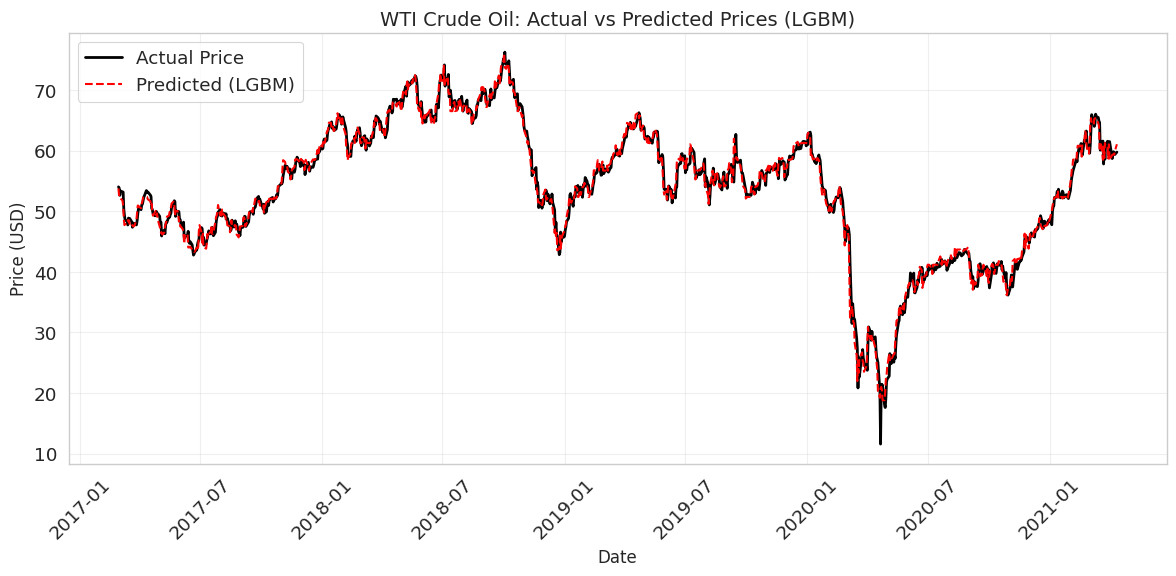


=== LGBM Test Set Performance ===
RMSE: 1.3104
MAE : 0.9392


In [ ]:
# =====================
# ACTUAL VS PREDICTED PLOT (LGBM)
# =====================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from sklearn.metrics import mean_squared_error, mean_absolute_error # Import metrics for clarity

# Assume you have:
# y_test (actual prices for test set, pandas Series with DatetimeIndex)
# y_pred (predicted prices for test set from the latest model, numpy array)

# Ensure y_test is a pandas Series with a DatetimeIndex
if not isinstance(y_test, pd.Series) or not isinstance(y_test.index, pd.DatetimeIndex):
    # Fallback or error handling if y_test is not in the expected format
    # Based on cell eCba6FcPVrPr, y_test should be a Series with DatetimeIndex
    # If not, you might need to re-run previous steps or adjust data loading
    print("Warning: y_test is not a pandas Series with DatetimeIndex. Plotting might fail.")
    # Attempt to use X_test_scaled_df index if available
    if 'X_test_scaled_df' in locals() and isinstance(X_test_scaled_df, pd.DataFrame) and isinstance(X_test_scaled_df.index, pd.DatetimeIndex):
         test_index = X_test_scaled_df.index
         print("Using index from X_test_scaled_df for plotting.")
    else:
         raise TypeError("Could not find a suitable DatetimeIndex for plotting.")
else:
    test_index = y_test.index


# Ensure y_pred is a numpy array or can be converted to one
y_pred_array = np.asarray(y_pred)

# Create plotting DataFrame
# Use the index from y_test (or X_test_scaled_df) for the dates
plot_df = pd.DataFrame({
    'Actual': y_test.values, # Use .values to align with numpy array y_pred
    'Predicted': y_pred_array
}, index=test_index) # Use the test_index for the DataFrame index


# 4) Generate the plot
plt.figure(figsize=(12, 6))
plt.plot(plot_df.index, plot_df['Actual'],
         label='Actual Price', color='black', linewidth=2)
plt.plot(plot_df.index, plot_df['Predicted'],
         label='Predicted (LGBM)', color='red', linestyle='--', linewidth=1.5)

# 5) Formatting
plt.title('WTI Crude Oil: Actual vs Predicted Prices (LGBM)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend(loc='upper left')
plt.grid(alpha=0.3)

# Date formatting
ax = plt.gca()
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

# Optional: Print performance metrics again
print("\n=== LGBM Test Set Performance ===")
print(f"RMSE: {sqrt(mean_squared_error(y_test, y_pred_array)):.4f}")
print(f"MAE : {mean_absolute_error(y_test, y_pred_array):.4f}")

In [ ]:
from sklearn.tree import DecisionTreeRegressor
# 4) AdaBoost Modelling with RandomizedSearchCV for Comparison
lookback_ada = X_train_scaled.shape[1]
param_dist_ada = {
    'n_estimators': [1000],
    'learning_rate': [0.001],
    'estimator__max_depth': [3]
}

tscv_ada = TimeSeriesSplit(n_splits=5)

base_est = DecisionTreeRegressor(random_state=42)
# Changed base_estimator to estimator
ada = AdaBoostRegressor(estimator=base_est, random_state=42)

search_ada = RandomizedSearchCV(
    estimator           = ada,
    param_distributions = param_dist_ada,
    n_iter              = 30,
    cv                  = tscv_ada,
    scoring             = 'neg_root_mean_squared_error',
    random_state        = 42,
    n_jobs              = -1,
    verbose             = 1
)

def run_ada_tscv(X_tr, y_tr, X_te, y_te):
    start = time.time()
    search_ada.fit(X_tr, y_tr)
    print(f"AdaBoost RandomizedSearchCV took {time.time() - start:.1f}s\n")

    best_ada = search_ada.best_estimator_
    preds    = best_ada.predict(X_te)
    rmse_ada = sqrt(mean_squared_error(y_te, preds))
    mae_ada  = mean_absolute_error(y_te, preds)

    print(f"Number of lags (lookback): {lookback_ada}")
    print("=== AdaBoost Test Set Performance ===")
    print(f"RMSE: {rmse_ada:.4f}, MAE: {mae_ada:.4f}")
    print("Best AdaBoost parameters:", search_ada.best_params_,"\n")

    return search_ada, best_ada

ada_rand, best_ada   = run_ada_tscv(X_train_scaled, y_train, X_test_scaled, y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=30. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
AdaBoost RandomizedSearchCV took 21.9s

Number of lags (lookback): 3
=== AdaBoost Test Set Performance ===
RMSE: 1.2557, MAE: 0.8498
Best AdaBoost parameters: {'n_estimators': 1000, 'learning_rate': 0.001, 'estimator__max_depth': 3} 



In [ ]:
# 5) CatBoost Modelling with RandomizedSearchCV for Comparison
lookback_cat = X_train_scaled.shape[1]
param_dist_cat = {
    'iterations': [1000],
    'depth':      [3],
    'learning_rate': [0.001],
}

tscv_cat = TimeSeriesSplit(n_splits=5)
cat_base = CatBoostRegressor(verbose=0, random_state=42)

search_cat = RandomizedSearchCV(
    estimator           = cat_base,
    param_distributions = param_dist_cat,
    n_iter              = 30,
    cv                  = tscv_cat,
    scoring             = 'neg_root_mean_squared_error',
    random_state        = 42,
    n_jobs              = -1,
    verbose             = 1
)

def run_cat_tscv(X_tr, y_tr, X_te, y_te):
    start = time.time()
    search_cat.fit(X_tr, y_tr)
    print(f"CatBoost RandomizedSearchCV took {time.time() - start:.1f}s\n")

    best_cat = search_cat.best_estimator_
    preds    = best_cat.predict(X_te)
    rmse_cat = sqrt(mean_squared_error(y_te, preds))
    mae_cat  = mean_absolute_error(y_te, preds)

    print(f"Number of lags (lookback): {lookback_cat}")
    print("=== CatBoost Test Set Performance ===")
    print(f"RMSE: {rmse_cat:.4f}, MAE: {mae_cat:.4f}")
    print("Best CatBoost parameters:", search_cat.best_params_,"\n")

    return search_cat, best_cat

cat_rand, best_cat   = run_cat_tscv(X_train_scaled, y_train, X_test_scaled, y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=30. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
CatBoost RandomizedSearchCV took 4.4s

Number of lags (lookback): 3
=== CatBoost Test Set Performance ===
RMSE: 1.2557, MAE: 0.8487
Best CatBoost parameters: {'learning_rate': 0.001, 'iterations': 1000, 'depth': 3} 



In [ ]:
import time
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from sklearn.neural_network import MLPRegressor

models = {
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'SVR (RBF)'   : SVR(),  # default RBF kernel
    'KNeighborsRegressor' : KNeighborsRegressor(n_neighbors=5),
    'RandomForestRegressor' : RandomForestRegressor(n_estimators=1000, random_state=42),
    'ExtraTrees (100)'   : ExtraTreesRegressor(n_estimators=1000, random_state=42)
}

for name, model in models.items():
    start = time.time()
    model.fit(X_train, y_train)
    elapsed = time.time() - start

    preds = model.predict(X_test_scaled)
    rmse  = sqrt(mean_squared_error(y_test, preds))
    mae   = mean_absolute_error(y_test, preds)

    print(f"{name:12s} → RMSE: {rmse:.4f}, MAE: {mae:.4f}, Train time: {elapsed:.4f}s")


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


DecisionTree → RMSE: 1.2909, MAE: 0.9875, Train time: 0.5836s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


SVR (RBF)    → RMSE: 0.8887, MAE: 0.6658, Train time: 1.0336s
KNeighborsRegressor → RMSE: 0.9762, MAE: 0.7415, Train time: 0.0082s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RandomForestRegressor → RMSE: 0.8945, MAE: 0.6719, Train time: 94.6344s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(


ExtraTrees (100) → RMSE: 0.8935, MAE: 0.6716, Train time: 20.3456s


In [ ]:
Xw_tr_seq = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
Xw_te_seq = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# 8.2) Build the model:
model = Sequential([
    LSTM(200, input_shape=(1, X_train_scaled.shape[1])),
    Dense(50, activation='relu'),
    Dropout(0.5),
    Dense(1)                        # ← this final layer gives a single output
])
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

# 8.3) Train & time it
start = time.time()
model.fit(
    Xw_tr_seq, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)
elapsed = time.time() - start

# 8.4) Predict & evaluate
y_pred = model.predict(Xw_te_seq).flatten()
rmse_lstm = sqrt(mean_squared_error(y_test, y_pred))
mae_lstm  = mean_absolute_error(y_test, y_pred)

print(f"LSTM (200→Dense50→1, lr=0.01) → RMSE: {rmse_lstm:.4f}, MAE: {mae_lstm:.4f}")
print(f"Training time: {elapsed:.2f} seconds")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 2.0347 - val_loss: 6.7499
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.8258 - val_loss: 6.9348
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.7774 - val_loss: 6.8152
Epoch 4/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.8124 - val_loss: 7.0108
Epoch 5/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.9073 - val_loss: 7.1623
Epoch 6/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.8007 - val_loss: 6.8848
Epoch 7/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.8016 - val_loss: 6.8985
Epoch 8/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6548 - val_loss: 9.4167
Epoch 9/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7860 - val_loss: 6.6734
Epoch 10/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.8058 - val_loss: 7.2263
Epoch 11/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.8140 - val_loss: 8.0658
Epoch 12/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6221 - val